# 🧠 Brain Tumor Classification using VGG16

## 📌 Project Overview

In this notebook, we will develop a deep learning model to automatically detect and classify brain tumors from MRI images. The goal of this project is to assist medical professionals in identifying four specific categories of brain conditions:

- **Glioma Tumor**
- **Meningioma Tumor**
- **Pituitary Tumor**
- **No Tumor**

Accurate and early detection of brain tumors is crucial for effective treatment planning and improved patient outcomes. Manual diagnosis from MRI scans can be time-consuming and subjective, so our goal is to build a model that can support this process with high accuracy and consistency.

---

## 🧰 What We'll Do

- Load and preprocess a labeled dataset of brain MRI images.
- Visualize example images from each tumor category.
- Use **transfer learning** with the **VGG16** architecture, a pre-trained Convolutional Neural Network originally trained on ImageNet.
- Fine-tune the model for multi-class classification specific to our problem.
- Evaluate the model’s performance using accuracy, confusion matrix, and classification report.
- Test the model on new images to validate its predictions.

---

## 🧠 Why VGG16?

VGG16 is a widely used CNN architecture known for its simplicity and strong performance in image classification tasks. By leveraging a pre-trained version of VGG16, we can reduce training time and achieve better performance, especially when working with a limited dataset.

---

Let's get started with loading the data and exploring the dataset!

## Load data and import libraries

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.callbacks import EarlyStopping

os.listdir(path)
training_data=path+'/Training'
testing_data=path+'/Testing'
os.listdir(training_data)

['pituitary', 'notumor', 'meningioma', 'glioma']

In [3]:
x=[]
y=[]
def load_data(path, x, y):
  x.clear()
  y.clear()
  for i in os.listdir(path):
    for j in os.listdir(path+'/'+i):
      img=cv2.imread(path+'/'+i+'/'+j)
      img=cv2.resize(img,(224,224))
      x.append(img)
      y.append(i)


load_data(training_data, x, y)

In [4]:
len(x),len(y)

(5712, 5712)

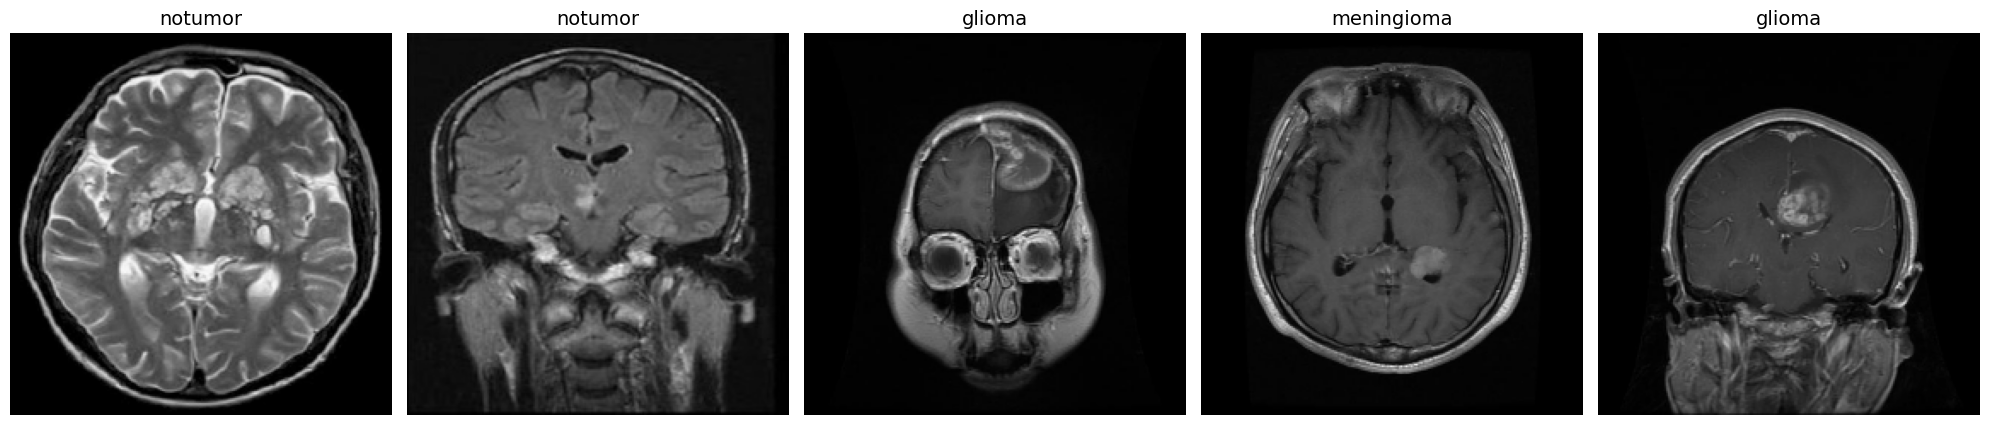

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    index = np.random.randint(len(x))
    axes[i].imshow(x[index])
    axes[i].set_title(str(y[index]), fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
y=np.array(y)
y=[0 if i=='glioma' else 1 if i=='meningioma' else 2 if i=='pituitary' else 3 for i in y]
y = np.array(y)


## split to train and valid

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_vald,y_train,y_vald=train_test_split(x,y,test_size=0.2,random_state=42)

In [8]:
len(x_train),len(x_vald)

(4569, 1143)

## model training

 - We use VGG16 for tumor detection even though it wasn’t originally trained on tumor images because it has already learned to recognize general image features like edges and shapes from a large dataset of everyday pictures (e.g., animals, objects).

- These learned features are useful across many types of images, including medical scans.

- Using the pretrained VGG16 model means we don’t have to train from scratch, which saves time and resources.

- We fine-tune the later layers of VGG16 with tumor images so the model can learn to identify tumors specifically.

- This approach works well because tumor datasets are often small, and training a deep model from zero is difficult and less effective.










In [9]:
VGG16_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in VGG16_model.layers:
  layer.trainable=False

In [10]:
model=Sequential()
model.add(VGG16_model)
model.add(Flatten())
model.add(Dense(4,activation='softmax'))
model.summary()

EarlyStopping=EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Precision'])

### Data Augmentation for Generalization and train the model

In [12]:
datagen = ImageDataGenerator(
    rotation_range=25,
    brightness_range=[0.5, 1.5]
)

batch_size = 32

# Convert x_train to numpy array and one-hot encode y_train
x_train_np = np.array(x_train)
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_vald, num_classes=4)


generator = datagen.flow(x_train_np, y_train_encoded, batch_size=batch_size)

history=model.fit(generator, epochs=10, steps_per_epoch=len(x_train)//batch_size, validation_data=(np.array(x_vald), y_test_encoded),callbacks=[EarlyStopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 110s 675ms/step - Precision: 0.7407 - loss: 6.4341 - val_Precision: 0.8924 - val_loss: 2.6162
Epoch 2/10
  1/142 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - Precision: 0.9375 - loss: 0.1193

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Precision: 0.9375 - loss: 0.1193 - val_Precision: 0.8871 - val_loss: 2.6922
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 72s 504ms/step - Precision: 0.9105 - loss: 1.6815 - val_Precision: 0.9213 - val_loss: 1.8525
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Precision: 0.9375 - loss: 1.3754 - val_Precision: 0.9134 - val_loss: 1.8884
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 500ms/step - Precision: 0.9507 - loss: 0.7926 - val_Precision: 0.9309 - val_loss: 2.1487
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - Precision: 0.9688 - loss: 0.0245 - val_Precision: 0.9309 - val_loss: 2.1047
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 500ms/step - Precision: 0.9569 - loss: 0.7819 - val_Precision: 0.9143 - val_loss: 2.6993
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - Precision: 0.9375 - loss: 1.0269 - val_Precision: 0.9081 - val_loss: 3.0103
Epoch 8: early stopping


## evaluation

### load test data

In [13]:
x_text=[]
y_test=[]

def load_data(path):
  for i in os.listdir(path):
    for j in os.listdir(path+'/'+i):
      img=cv2.imread(path+'/'+i+'/'+j)
      img=cv2.resize(img,(224,224))
      x_text.append(img)
      y_test.append(i)



load_data(testing_data)
y_test=np.array(y_test)
print(len(x_text),len(y_test))
y_test=[0 if i=='glioma' else 1 if i=='meningioma' else 2 if i=='pituitary' else 3 for i in y_test]
y_test = np.array(y_test)

1311 1311


In [14]:
y_pred=model.predict(np.array(x_text))

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 430ms/step


In [15]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       300
           1       0.94      0.73      0.82       306
           2       0.93      0.98      0.95       300
           3       0.98      1.00      0.99       405

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.91      1311
weighted avg       0.92      0.92      0.92      1311



## save model

In [19]:
model.save("model.keras", save_format="keras")